In [1]:
#Library imports

#Locate the files in their respective directories
import os
import pandas as pd

#Plot 
import numpy as np
import matplotlib.pyplot as plt

#PyTprch Libraries needed for the implementation of the network
import torch
import torch.nn as nn  
import torch.optim as optim  
import torchvision.transforms as transforms  
import torchvision
from torch.utils.data import (Dataset,DataLoader) 


#load and preprocess the images
from PIL import Image
from skimage import io

#Get computation time
import time

In [2]:
directory = os.getcwd() # Path of the current working directory.
print(directory)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f" {device} being used")

C:\Users\Andreas\Desktop\AMLS_22-23_SN18086046
 cpu being used


In [3]:
epochs = 5 #complete passess over the data set
classes = 2 #male/female or smile/no-smile
batch_size = 200 #data must be loaded in batches for more efficient training (high batch size can lead to memory overload)
learning_rate = 0.001

In [4]:
class celeba_smile_Dataset(Dataset):
    def __init__(self,csv_file,root_dir,transform=None):
        self.annotations=pd.read_csv(csv_file)
        self.root_dir=root_dir
        self.transform=transform
        pass
  
    def __len__(self):
        
        return len(self.annotations)
        pass
    def __getitem__(self, index): #PyTorch chooses the index
        img_path=os.path.join(self.root_dir, self.annotations.iloc[index,1]) #The 2nd column contains the image names
        image=io.imread(img_path)
        y_label=torch.tensor(int(self.annotations.iloc[index,3])) #the 4th column contains the smiling labels
        y=(y_label+1)/2 #get 0 and 1 for labels instead of -1 and 1
        yt=y.type(torch.LongTensor) #transform to tensor as PyTorch reads only tensors
        if self.transform:
            image=self.transform(image)
        return (image,yt)
        
        pass


In [5]:
#reduce image size
tf=transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((160,160)), #from [178,218]
    transforms.ToTensor()
])

dataset=celeba_smile_Dataset(csv_file='Datasets/dataset_AMLS_22-23/celeba/labels.csv',
                      root_dir='Datasets/dataset_AMLS_22-23/celeba/img',transform=tf)                                                                                            
                                                                                            
#split the images into test and validation sets
train_dataset,val_dataset=torch.utils.data.random_split(dataset,[4000,1000]) 
train_loader=DataLoader(dataset=train_dataset,batch_size=200,shuffle=True)
val_loader=DataLoader(dataset=val_dataset,batch_size=200,shuffle=False)
#shuffle=True to ensure our model is not biased for some categories 

print('Train dataset size:', len(train_dataset)) #must give 4000
print('Validation dataset size:',len(val_dataset)) #must give 1000
print(batch_size) #must give 200

Train dataset size: 4000
Validation dataset size: 1000
200


In [6]:
#CNN model
class convNet(nn.Module):
    def __init__(self,classes=2):
        super(convNet,self).__init__()
        
        #Input shape =(batch_size,RGB_channel,Image dimensions)=(200,3,160,160)
        #The first convolutional layer
        self.conv1=nn.Conv2d(in_channels=3,out_channels=10,kernel_size=(5,5),stride=1,padding=2)
        self.norm1=nn.BatchNorm2d(num_features=10) #normalisation
        self.relu1=nn.ReLU()
        #Shape=(200,10,160,160)
        
        self.pool1=nn.MaxPool2d(kernel_size=(2,2))
        #reduce dimensions of image by a factor of 2
        #Shape= (200,10,80,80)
        
        #second convolutional layer
        self.conv2=nn.Conv2d(in_channels=10,out_channels=20,kernel_size=(5,5),stride=1,padding=2)
        self.norm2=nn.BatchNorm2d(num_features=20)
        self.relu2=nn.ReLU()
        
        #Shape= (200,20,80,80)
        self.pool2=nn.MaxPool2d(kernel_size=(2,2))
        #Shape= (200,20,40,40)
        
        
        #Third convolutional layer
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=(5,5),stride=1,padding=2)
        self.norm3=nn.BatchNorm2d(num_features=32)
        self.relu3=nn.ReLU()
        #Shape= (200,32,40,40)
        
        #fully connected layer
        self.fc=nn.Linear(in_features=32*40*40,out_features=classes)
        
        
        #feed forward function
    def forward(self,input):
        output=self.conv1(input)
        output=self.norm1(output)
        output=self.relu1(output)
        output=self.pool1(output)
            
        output=self.conv2(output)
        output=self.norm2(output)
        output=self.relu2(output)
        output=self.pool2(output)
            
        output=self.conv3(output)
        output=self.norm3(output)
        output=self.relu3(output)
            
            
        #output end shape (200,32,40,40)
            
        output=output.view(-1,32*40*40)
            
            
        output=self.fc(output)
            
        return output

In [7]:
model=convNet(classes=2).to(device) #send it to cuda/cpu

#Loss and optimizer functions
optimizer=torch.optim.Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
criterion=nn.CrossEntropyLoss()


Cost at epoch 0 is 1.5363693237304688
Cost at epoch 1 is 0.8701634109020233
Cost at epoch 2 is 0.6617282927036285
Cost at epoch 3 is 0.552854374051094
Cost at epoch 4 is 0.47267145812511446


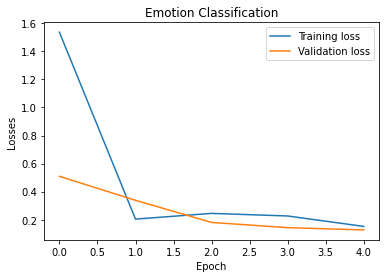

Getting Training set accuracy....
 3871 / 4000 correct images with accuracy 96.78%
Getting Validation set accuracy....
 970 / 1000 correct images with accuracy 97.00%
Time taken: 637.7598268985748 seconds


In [8]:
# Train Network
start_time=time.time()

#empty list for training and validation losses
train_losses = []
val_losses=[]

#Loop over 5 epochs
for epoch in range(epochs):
    
    #Loop over each batch
    for  batch_index, (train_data,train_targets) in enumerate(train_loader):
        
        # Get data 
        train_data = train_data.to(device=device)
        train_targets = train_targets.to(device=device)
        
        # forward pass (Evaluation)
        train_output = model(train_data)
        train_loss = criterion(train_output, train_targets)
        
        # Clear and calculate gradients
        optimizer.zero_grad()
        train_loss.backward()
        # adam step
        optimizer.step()
        
    #Append the train losses from each batch
    train_losses.append(train_loss.item())
    
    print(f"Cost at epoch {epoch} is {sum(train_losses)/len(train_losses)}")
    
    #Same loop for validation set
    for batch_index, (val_data,val_targets) in enumerate(val_loader):
        
        # Get data 
        val_data = val_data.to(device=device)
        val_targets =val_targets.to(device=device)
        
        # forward pass (Evaluation)
        val_output = model(val_data)
        val_loss = criterion(val_output,val_targets)
        
        # Clear and calculate gradients
        optimizer.zero_grad()
        val_loss.backward()
        # adam step
        optimizer.step()
    
    #Append the validation losses from each batch
    val_losses.append(val_loss.item())
    

#plot the Train and Validation costs
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Losses")
plt.title("Emotion Classification")
plt.show() 

   

# Check accuracy on training to see how good our model is
def check_accuracy(loader, model):
    num_correct = 0
    num_total= 0
    
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device=device)
            labbels = labels.to(device=device)

            output = model(images)
            _, predictions = output.max(1)
            num_correct += (predictions == labels).sum()
            num_total += predictions.size(0)

        print( f" {num_correct} / {num_total} correct images with accuracy {float(num_correct)/float(num_total)*100:.2f}%")
        
    model.train()


print("Getting Training set accuracy....")
check_accuracy(train_loader, model)
    
print("Getting Validation set accuracy....")
check_accuracy(val_loader, model)  

elapsed_time=time.time()
print('Time taken:',(elapsed_time-start_time),'seconds')

#Save the model
torch.save(model.state_dict(), 'A2_emotion_model.ckpt')


In [10]:
#Load the test set
test_dataset=celeba_smile_Dataset(csv_file='Datasets/dataset_AMLS_22-23_test/celeba_test/labels.csv',
                      root_dir='Datasets/dataset_AMLS_22-23_test/celeba_test/img',transform=tf)

test_loader=DataLoader(dataset=test_dataset,batch_size=200,shuffle=False)

print('Test dataset size:',len(val_dataset)) #must give 1000
print(len(test_loader)) #must give 5

Test dataset size: 1000
5


In [12]:
#Load the model
model.load_state_dict(torch.load('A2_emotion_model.ckpt'))
model.eval()
#in_features=32*40*40=51200 , out_features= no. of classes

convNet(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (norm1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (norm2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (norm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc): Linear(in_features=51200, out_features=2, bias=True)
)

In [13]:
print("Getting Test set accuracy....")
check_accuracy(test_loader, model) 

Getting Test set accuracy....
 882 / 1000 correct images with accuracy 88.20%
